In [1]:
import glob
from os.path import abspath 
import json

import pandas as pd 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pygmo as pg
import numpy as np

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(14,8)})

# --- open several .csv files
def get_data(path):
    df_group = [pd.read_pickle(i_path) for i_path in glob.glob(path)]
    return pd.concat(df_group)

# --- unzip non-dominated results into rows
def explode_ndf(df):
    df['zip'] = df[['ndf_f', 'ndf_x']].apply(lambda row: list(zip(*row.values)), axis=1)
    df.drop(['ndf_f', 'ndf_x'], axis=1, inplace=True)
    df = df.explode('zip')
    
    df = pd.concat([df.reset_index(drop=True), 
               pd.DataFrame.from_records(df['zip'].values, columns=['obj', 'params'])],
              axis=1).drop('zip', 1)
    
    # --- column for each objective     
    obj_df = pd.DataFrame.from_records(df['obj'].values, columns=df['objectives'].iloc[0])
    df = pd.concat([df.reset_index(drop=True), obj_df],
          axis=1).drop(['obj', 'objectives'], 1)

    return df   

# --- inverse maximization metric
def inverse(cell):
    for row in range(len(cell)):
        cell[row][0] = 1 - cell[row][0] 
        
# --- Compute Hypervolume
def compute_hypervolume(row, ref_point):
    hypervolume = pg.hypervolume(row["ndf_f"]).compute(ref_point) 
    row["hypervolume"] = hypervolume
    return row

In [2]:
raw_df = get_data("results_paper/open_ml_1510/*RF*.pkl")

In [3]:
df = get_data("results_paper/open_ml_1510/*RF*.pkl")
df = explode_ndf(df)
df['dataset'] = 1510

<AxesSubplot:xlabel='iteration', ylabel='ndf_size_%'>

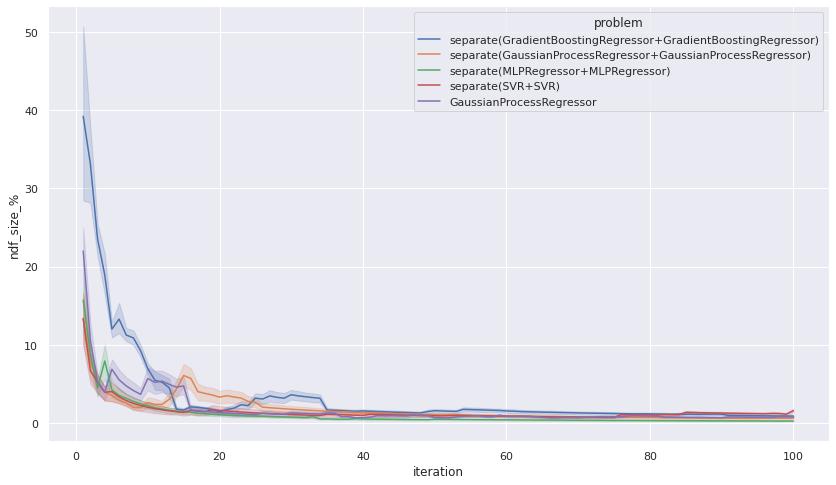

In [4]:
df['ndf_size_%'] = df['ndf_size'] / (df['iteration']*10) * 100
df['test_roc_auc_%'] = df['test_roc_auc'] * 100
df['fit_time_%'] = (1 - df['fit_time'] / df.max()["fit_time"]) * 100


sns.lineplot(x="iteration", 
             y="ndf_size_%", 
             hue="problem",
             data=df)

In [5]:
#integrate ndf_size_% surrogate-wise using the trapezodial rule
df["ndf_size_%_area"] = 0
for p in df.problem.unique():
    problem_wise_df = df[df.problem == p]
    area = np.trapz(y=problem_wise_df["ndf_size_%"])
    df["ndf_size_%_area"] = df["ndf_size_%_area"].where(df.problem != p, area)

In [6]:
# Hypervolume
# find a reference point = [1 - min roc_auc, max fit_time] 
# roc_auc is inversed for minimization

df.max()["fit_time"]
ref_point = np.array([1 - df.min()["test_roc_auc"], df.max()["fit_time"]])

In [7]:
raw_df["ndf_f"].apply(lambda x: inverse(x))

0     None
1     None
2     None
3     None
4     None
      ... 
95    None
96    None
97    None
98    None
99    None
Name: ndf_f, Length: 2500, dtype: object

In [8]:
raw_df = raw_df.apply(lambda row: compute_hypervolume(row, ref_point), axis=1)

In [9]:
#integrate hypervolume surrogate-wise using the trapezodial rule
import scipy.integrate as integrate

raw_df["hypervolume_area"] = 0
for p in raw_df.problem.unique():
    problem_wise_df = raw_df[raw_df.problem == p]
    area = np.trapz(y=problem_wise_df["hypervolume"])
    raw_df["hypervolume_area"] = raw_df["hypervolume_area"].where(raw_df.problem != p, area)

<AxesSubplot:xlabel='iteration', ylabel='hypervolume'>

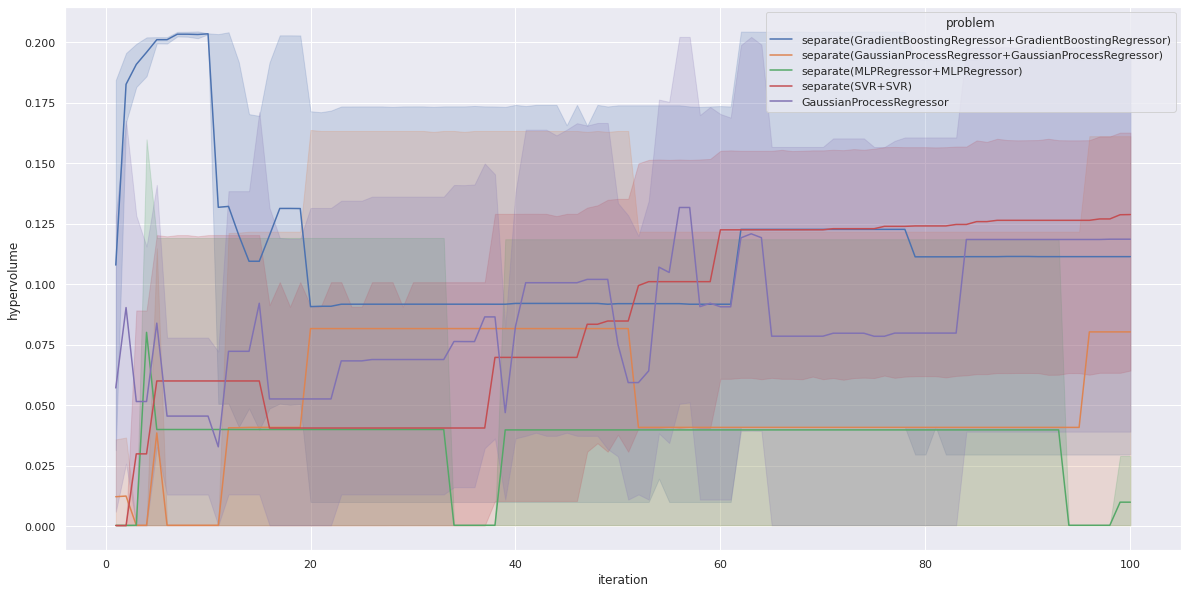

In [10]:
f, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(x="iteration", 
             y="hypervolume", 
             hue="problem",
             data=raw_df)

# sns.lineplot(x="iteration", 
#              y="test_roc_auc_%", 
# #              hue="model_id",
#              data=df)

# sns.lineplot(x="iteration", 
#              y="fit_time_%", 
# #              hue="model_id",
#              data=df)

# plt.legend(loc='upper left', labels=['ndf_size_%', 'test_roc_auc_%', 'fit_time_%'])

In [11]:
merged_df = df.merge(raw_df)
result_df = merged_df[merged_df.iteration==100]
result_df = result_df.groupby(["problem"]).mean()
result_df

,iteration,feature_dim,ndf_size,i_time,model_id,test_roc_auc,fit_time,dataset,ndf_size_%,test_roc_auc_%,fit_time_%,ndf_size_%_area,hypervolume,hypervolume_area
problem,,,,,,,,,,,,,,
GaussianProcessRegressor,100.0,7.0,7.642857,37132.817750,1.405070e+14,0.699362,0.016542,1510.0,0.764286,69.936197,96.227827,2646.279382,0.163148,42.251136
separate(GaussianProcessRegressor+GaussianProcessRegressor),100.0,7.0,6.263158,47895.093615,1.402225e+14,0.700074,0.017818,1510.0,0.626316,70.007389,95.936803,2533.151071,0.158291,25.939009
separate(GradientBoostingRegressor+GradientBoostingRegressor),100.0,7.0,8.600000,4473.166185,1.405180e+14,0.799164,0.015702,1510.0,0.860000,79.916422,96.419306,8864.671192,0.159164,57.028684
separate(MLPRegressor+MLPRegressor),100.0,7.0,2.400000,1165.646793,1.401438e+14,0.511265,0.017280,1510.0,0.240000,51.126451,96.059542,915.076938,0.009955,17.277844
separate(SVR+SVR),100.0,7.0,15.558140,1764.964651,1.400310e+14,0.826914,0.119858,1510.0,1.555814,82.691394,72.668224,2236.871933,0.159048,42.818817


<AxesSubplot:xlabel='test_roc_auc', ylabel='fit_time'>

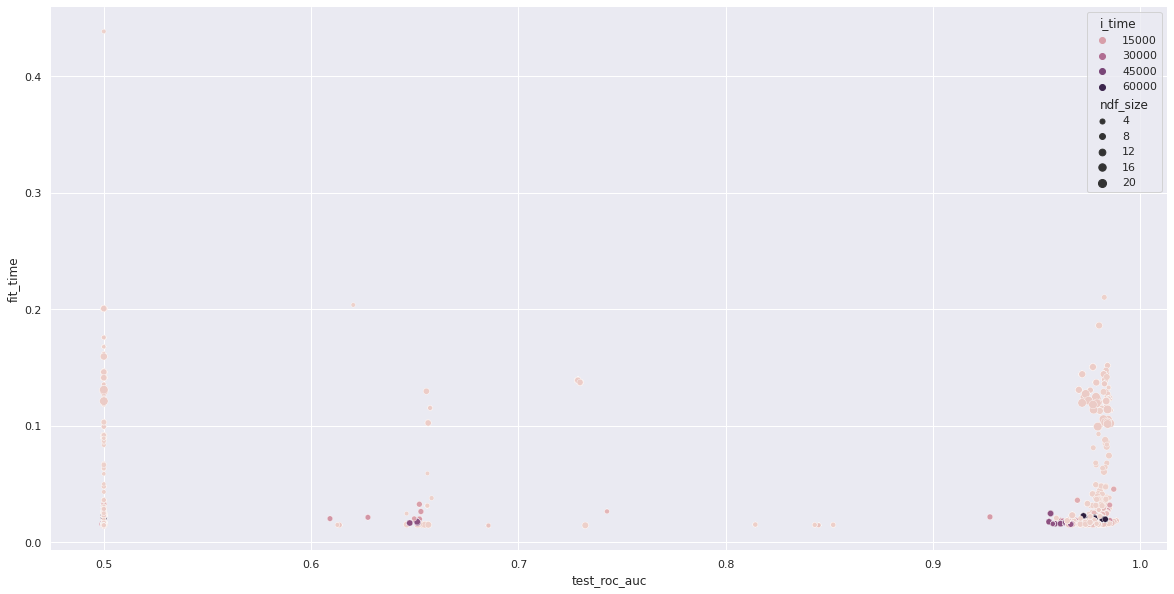

In [12]:
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="test_roc_auc", y="fit_time",
                hue="i_time", size="ndf_size",
                data=df, ax=ax)

## Final results: all samples

In [13]:
data = get_data("results_paper/open_ml_1049/dataset.*.pkl")
data

,criterion,max_depth,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,max_features,n_estimators,fit_time,score_time,test_f1,test_roc_auc
0,gini,61.000000,0.500000,0.250000,0.250000,sqrt,505,0.710772,0.094134,0.000000,0.858696
1,entropy,31.000000,0.750000,0.125000,0.375000,sqrt,752,0.972053,0.133970,0.000000,0.500000
2,gini,90.000000,0.250000,0.375000,0.125000,log2,257,0.373163,0.071908,0.000000,0.500000
3,gini,46.000000,0.625000,0.062500,0.437500,log2,133,0.186023,0.028879,0.000000,0.836822
4,entropy,105.000000,0.125000,0.312500,0.187500,sqrt,628,0.862586,0.116507,0.000000,0.788737
...,...,...,...,...,...,...,...,...,...,...,...
1005,entropy,59.098832,0.000047,0.000853,0.273343,sqrt,509,0.850374,0.114520,0.000000,0.875320
1006,entropy,58.341801,0.037465,0.000026,0.000225,sqrt,510,1.232074,0.106525,0.303726,0.931420
1007,entropy,59.098832,0.000018,0.013516,0.190025,sqrt,510,0.811232,0.100302,0.000000,0.882423
1008,entropy,59.655936,0.000018,0.000853,0.208446,sqrt,509,0.802147,0.100319,0.000000,0.877145


<AxesSubplot:xlabel='test_roc_auc', ylabel='fit_time'>

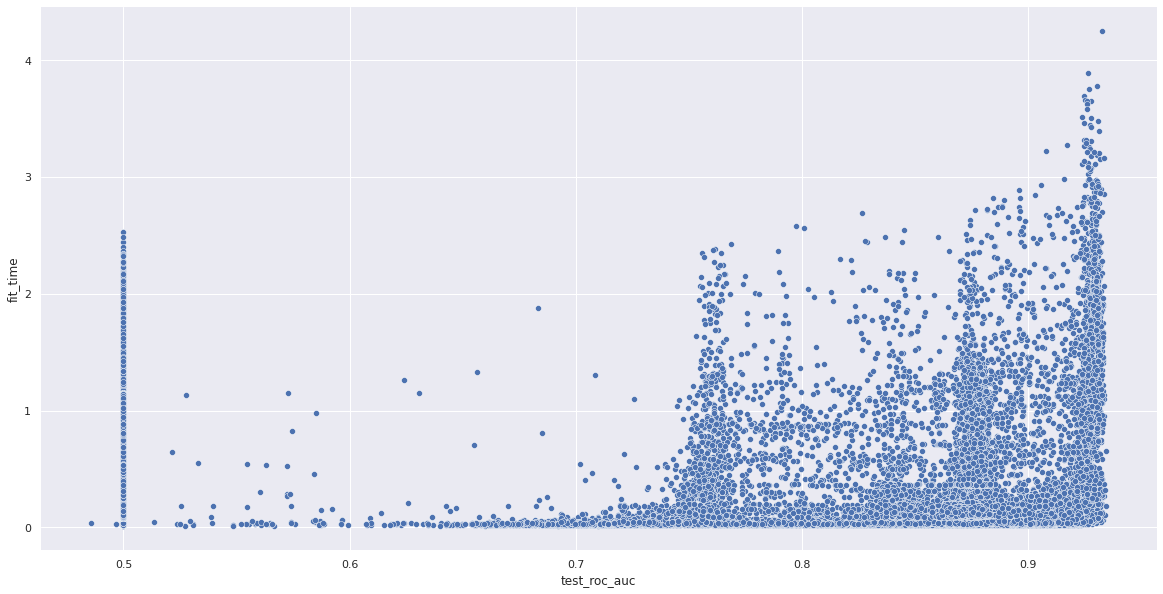

In [14]:
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="test_roc_auc", y="fit_time",
                data=data, ax=ax)

In [15]:
### Table dataset-wise
datasets = [1049, 1050, 31, 1471, 1510]
final_result = pd.DataFrame()
for d in datasets:
    raw_df = get_data("results_paper/open_ml_" + str(d) + "/*RF*.pkl")
    df = get_data("results_paper/open_ml_" + str(d) + "/*RF*.pkl")
    df = explode_ndf(df)
    df['ndf_size_%'] = df['ndf_size'] / (df['iteration']*10) * 100
    df['test_roc_auc_%'] = df['test_roc_auc'] * 100
    df['fit_time_%'] = (1 - df['fit_time'] / df.max()["fit_time"]) * 100
    df['dataset'] = d
    
    #integrate ndf_size_% surrogate-wise using the trapezodial rule
    df["ndf_size_%_area"] = 0
    for p in df.problem.unique():
        problem_wise_df = df[df.problem == p]
        area = np.trapz(y=problem_wise_df["ndf_size_%"])
        df["ndf_size_%_area"] = df["ndf_size_%_area"].where(df.problem != p, area)
    # Hypervolume
    # find a reference point = [1 - min roc_auc, max fit_time] 
    # roc_auc is inversed for minimization

    df.max()["fit_time"]
    ref_point = np.array([1 - df.min()["test_roc_auc"], df.max()["fit_time"]])
    raw_df["ndf_f"].apply(lambda x: inverse(x))
    raw_df = raw_df.apply(lambda row: compute_hypervolume(row, ref_point), axis=1)
    #integrate hypervolume surrogate-wise using the trapezodial rule
    raw_df["hypervolume_area"] = 0
    for p in raw_df.problem.unique():
        problem_wise_df = raw_df[raw_df.problem == p]
        area = np.trapz(y=problem_wise_df["hypervolume"])
        raw_df["hypervolume_area"] = raw_df["hypervolume_area"].where(raw_df.problem != p, area)
    
    
    merged_df = df.merge(raw_df)
    result_df = merged_df[merged_df.iteration==100]
    result_df = result_df.groupby(["problem", 'dataset']).mean()
    final_result = pd.concat([final_result, result_df])
final_result    


,,iteration,feature_dim,ndf_size,i_time,model_id,test_roc_auc,fit_time,ndf_size_%,test_roc_auc_%,fit_time_%,ndf_size_%_area,hypervolume,hypervolume_area
problem,dataset,,,,,,,,,,,,,
GaussianProcessRegressor,1049,100.0,7.0,4.333333,27661.534235,1.400532e+14,0.553374,0.016615,0.433333,55.337401,92.821946,2818.415192,0.030131,10.640770
separate(GaussianProcessRegressor+GaussianProcessRegressor),1049,100.0,7.0,3.400000,68723.889818,1.402175e+14,0.544983,0.021721,0.340000,54.498282,90.616196,1568.170545,0.021917,13.123745
separate(GradientBoostingRegressor+GradientBoostingRegressor),1049,100.0,7.0,2.272727,4423.950982,1.400756e+14,0.530121,0.015521,0.227273,53.012071,93.294615,5304.989713,0.016013,18.840519
separate(MLPRegressor+MLPRegressor),1049,100.0,7.0,4.100000,1372.261906,1.402749e+14,0.552720,0.020239,0.410000,55.271972,91.256369,2451.088274,0.043247,17.595689
separate(SVR+SVR),1049,100.0,7.0,12.191489,1508.901826,1.399679e+14,0.771413,0.118173,1.219149,77.141281,48.947971,6292.609116,0.048380,15.743393
GaussianProcessRegressor,1050,100.0,7.0,4.411765,54313.866791,1.404101e+14,0.616297,0.020827,0.441176,61.629732,90.390844,2149.032367,0.044563,15.082961
separate(GaussianProcessRegressor+GaussianProcessRegressor),1050,100.0,7.0,5.375000,43614.311388,1.400403e+14,0.575860,0.018095,0.537500,57.585969,91.651322,3439.965625,0.025663,10.316856
separate(GradientBoostingRegressor+GradientBoostingRegressor),1050,100.0,7.0,5.210526,5909.543727,1.403937e+14,0.697036,0.020080,0.521053,69.703623,90.735631,6526.321420,0.056476,25.278973
separate(MLPRegressor+MLPRegressor),1050,100.0,7.0,3.363636,1035.340757,1.403468e+14,0.500000,0.016300,0.336364,50.000000,92.479764,1449.110643,0.000000,5.443314


In [16]:
# group all datasets
final_result = final_result.groupby(["problem"]).mean()
final_result 

,iteration,feature_dim,ndf_size,i_time,model_id,test_roc_auc,fit_time,ndf_size_%,test_roc_auc_%,fit_time_%,ndf_size_%_area,hypervolume,hypervolume_area
problem,,,,,,,,,,,,,
GaussianProcessRegressor,100.0,7.0,6.578995,44283.281982,1.402940e+14,0.577786,0.037635,0.657900,57.778616,95.210065,4438.172804,0.384311,173.026228
separate(GaussianProcessRegressor+GaussianProcessRegressor),100.0,7.0,6.739298,55615.728306,1.402183e+14,0.578930,0.041132,0.673930,57.892991,95.052632,3250.784012,0.399383,177.228360
separate(GradientBoostingRegressor+GradientBoostingRegressor),100.0,7.0,4.974715,5113.339629,1.402995e+14,0.611075,0.019756,0.497472,61.107507,95.742367,7885.166610,0.383998,197.660135
separate(MLPRegressor+MLPRegressor),100.0,7.0,3.962471,1261.996136,1.402724e+14,0.509774,0.035775,0.396247,50.977401,95.415564,2780.810132,0.308622,164.168923
separate(SVR+SVR),100.0,7.0,9.944930,1634.718535,1.401665e+14,0.686560,0.149599,0.994493,68.656000,67.389016,2827.411887,0.377884,166.479167
